# The Basic Solow Model and COVID-19

Imports and set magics:

In [79]:
import numpy as np
from scipy import optimize
import sympy as sm
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Basic Solow Model


\begin{equation}
Y_t = AK_t^{\alpha}L_t^{1-\alpha} \tag{1}
\end{equation}
\begin{equation}
S_t = sY_t \tag{2}
\end{equation}
\begin{equation}
K_{t+1} - K_t = S_t -\delta K_t \tag{3}
\end{equation}
\begin{equation}
L_{t+1} = (1+n)L_t \tag{4}
\end{equation}
\begin{equation}
y_t = \frac{Y_t}{L_t} = Ak_t^{\alpha} \tag{5}
\end{equation}
\begin{equation}
k_t = \frac{K_t}{L_t} \tag{6}
\end{equation}




In [80]:
Y = sm.symbols("Y_t")          #GDP in the economy
y = sm.symbols("y_t")          #GDP per worker
K = sm.symbols("K_t")          #Capital in the economy
K_next = sm.symbols("K_{t+1}") #Capital in the economy next period
k = sm.symbols("k_t")          #Capital per worker
k_next = sm.symbols("k_{t+1}") #Capital per worker next period
s = sm.symbols("s")            #Rate of savings
n = sm.symbols("n")            #Population growth rate
g = sm.symbols("g")            #Growth in technology
A = sm.symbols("A")            #Total factor productivity
L = sm.symbols("L_t")          #Labour supply
L_next = sm.symbols("L_{t+1}") #Labour supply next period
alpha = sm.symbols("alpha")    #Share of capital out of output
delta = sm.symbols("delta")    #Depreciation rate on capital
kstar = sm.symbols("k^*")      #Steady state for capital
ystar = sm.symbols("y^*")      #Steady state for GDP per worker




In [81]:
r = sm.symbols("r_t")          #Real rental rate
w = sm.symbols("w_t")          #Real wage

\begin{equation}
r_t = \alpha A \left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{7}
\end{equation}
\begin{equation}
w_t = (1-\alpha) A \left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{8}
\end{equation}

We assert that the real rental rate and real wages are given as (7) and (8), using the Sympy package to find the derivatives of output with respecto capital and labour.

In [82]:
foc_wrt_K = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha), K)),r)
foc_wrt_K

Eq(A*K_t**(alpha - 1)*L_t**(1 - alpha)*alpha, r_t)

In [83]:
foc_wrt_L = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha), L)),w)
foc_wrt_L

Eq(-A*K_t**alpha*L_t**(-alpha)*(alpha - 1), w_t)

With our model written out and verified we now look at one of the core components of the basic Solow model, capital accumulation

# Capital Accumulation and Steady State Values


By inserting equation (1) in (2) and then inserting that in equation 3, finally we divide by equation (4) to end up at the transition equation.


In [84]:
Transition_equation = sm.simplify(sm.Eq((((1/(1+n))*(A*s*k**(alpha)+(1-delta)*k))), k_next))
Transition_equation

Eq(k_{t+1}, (A*k_t**alpha*s - k_t*(delta - 1))/(n + 1))

To find the steady state of capital, we use that $$\begin{equation}
k_{t+1}=k_t=k^*
\end{equation}$$
 in steady state.
 We turn to the Sympy's solver function


In [85]:
steady_state_capital = sm.solve(((A*s*kstar**(alpha)-(delta-1)*kstar)/(1+n)-kstar), kstar) 
sm.Eq(steady_state_capital[0], kstar)


Eq(((delta + n)/(A*s))**(1/(alpha - 1)), k^*)

In [86]:
sm.Eq(steady_state_capital[0], kstar)

Eq(((delta + n)/(A*s))**(1/(alpha - 1)), k^*)

substituting this result in equation (5), we get the following steady state output

In [87]:
steady_state_output = sm.simplify(A*steady_state_capital[0]**alpha)
sm.Eq(ystar, steady_state_output)

Eq(y^*, A*(((delta + n)/(A*s))**(1/(alpha - 1)))**alpha)

In [88]:
steady_state_capital_func = sm.lambdify((delta,n,A,s,alpha),steady_state_capital[0])

def _steady_state_capital_func(delta,n,A,s,alpha):
    """ Defines the parametrical relationships of the steady state capital as it is given in the Solow Model
    
    Args:
    
        delta (float): Depreciation rate on capital
        n     (float): Population growth rate
        A     (float): Total factor productivity
        s     (float): Rate of savings
        alpha (float): Share of capital out of output

    Returns:
    
       steady_state_capital_func: Steady State Capital Per Worky
    
    """   

    return steady_state_capital_func(delta,n,A,s,alpha)

  




To assert that our new function works we plot the function for different savings rates. Both analytically and theoretically we should see that capital is increasing in the savings rate, all else equal

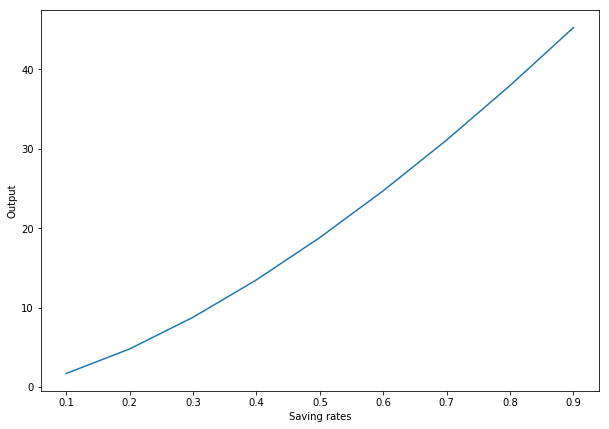

In [89]:
delta= 0.05
n= 0.02
A= 1
#labels = ("0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9",)
savings_vec = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
alpha = 0.33
steady_state_capital_func(delta,n,A,savings_vec,alpha)
plt.figure(figsize=(10,7))
plt.xlabel("Saving rates")
plt.ylabel("Output")
plt.plot(savings_vec,steady_state_capital_func(delta,n,A,savings_vec,alpha));

In [90]:
def solow_graph_1(k,delta,n,A,s,alpha):
    """  Defines the parametrical relationships of steady state output as it is given in the Solow Model
    
    Args:
    
        k     (float): Capital per worker
        delta (float): Depreciation rate on capital
        n     (float): Population growth rate
        A     (float): Total factor productivity
        s     (float): Rate of savings
        alpha (float): Share of capital out of output

    Returns:
    
      deltavec    : Plots total depreciation over time including                              population growths - to ensure a 45 degree line

      svec        : plots total output at different savings rates

    """


        # savings path
    svec = []
        # depreciation path
    deltavec = []

    for t in range(1,k):
        depreciation = (delta+n)*t
        deltavec.append(depreciation)
   

    for t in range(1,k):
        savings = s*A*t**alpha
        svec.append(savings)
    
    #for t in range(1, k):
        #k_extended = A*t**alpha
        #yvec.append(k_extended)
    
#$sAk_t^{\u03B1}$'

    plt.figure(figsize=(15,15))
    plt.plot(deltavec[:k], label = '$(n+\delta)k_t$', color = 'black')
    #plt.plot(kvec[:k], label='$Ak_t^{\u03B1}$', color = 'blue')
    plt.plot(svec[:k], color = 'green')
    #for y, label in zip(savings_vec, labels):
        #plt.plot(svec[:k], label=label)
    plt.xlim(0,k)
    plt.ylim(0,deltavec[-1])
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    plt.legend(['$(n+\delta)k_t$', '$sAk_t^{\u03B1}$, s=0.9', '$sAk_t^{\u03B1}$, s=0.8', '$sAk_t^{\u03B1}$, s=0.7', '$sAk_t^{\u03B1}$, s=0.6', '$sAk_t^{\u03B1}$, s=0.5', '$sAk_t^{\u03B1}$, s=0.4', '$sAk_t^{\u03B1}$, s=0.3', '$sAk_t^{\u03B1}$, s=0.2', '$sAk_t^{\u03B1}$, s=0.1'])
    return plt.show()

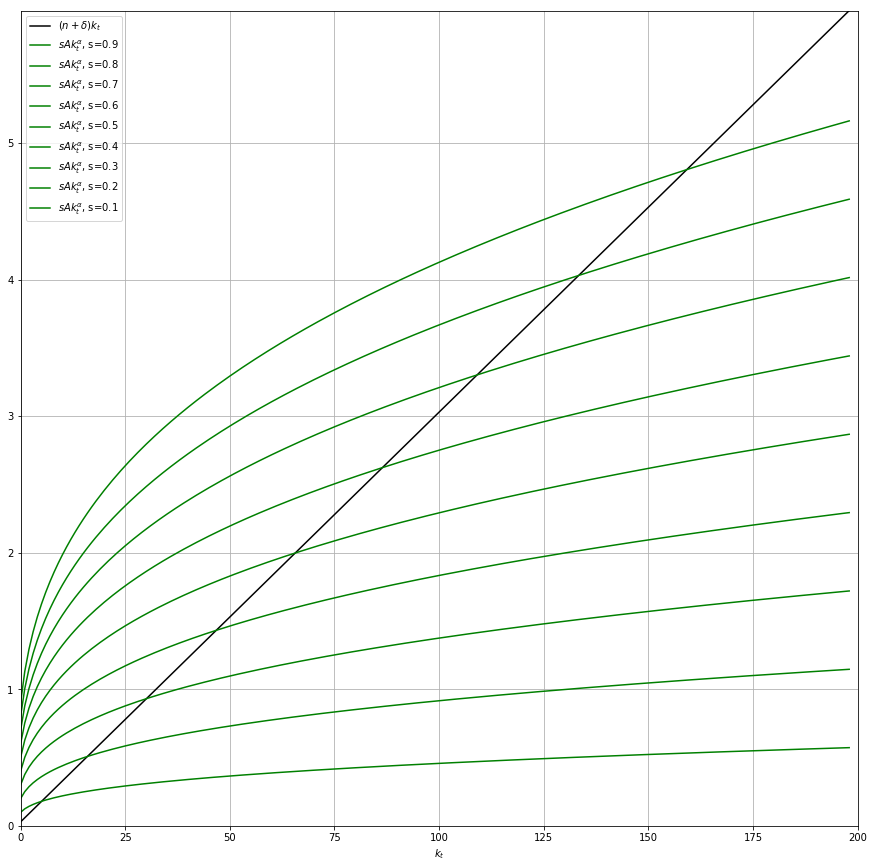

In [91]:
solow_graph_1(200,0.02,0.01,1,savings_vec,0.33)

Underneath, we have added a widget that lets you control the parameters

In [92]:
widgets.interact(solow_graph_1, 
                k_0     = widgets.fixed(0), 
                alpha = widgets.FloatSlider(description = '\u03B1' , min = 0 ,    max = 0.9 , step = 0.01 , value = 0.33),
                delta = widgets.FloatSlider(description = '\u03B4' , min = 0 ,    max = 0.1 , step = 0.01 , value = 0.01),
                s     = widgets.FloatSlider(description = 's' ,        min = 0.01, max = 0.9 , step = 0.01 , value = 0.4),
                n     = widgets.FloatSlider(description ='n',        min = -0.1 , max = 0.1 , step = 0.005, value = 0.01),
                A     = widgets.fixed(1),
                k     = widgets.IntSlider(description='k' ,          min = 1,     max = 1001, step = 10,    value = 100))

interactive(children=(IntSlider(value=100, description='k', max=1001, min=1, step=10), FloatSlider(value=0.01,…

<function __main__.solow_graph_1(k, delta, n, A, s, alpha)>

Finally we can plot the transition in terms of output. We show this by plotting capital, total depreciation and output. As total depreciation and growth in capital converge, we see that output growth also converges to 0

In [93]:
def solow_equation(k, delta, n, A, s, alpha):
    """  defines the outcomes of the Solow model as specified by the model equations
    
    Args:
    
        k     (float): Capital per worker
        delta (float): Depreciation rate on capital
        n     (float): Population growth rate
        A     (float): Total factor productivity
        s     (float): Rate of savings
        alpha (float): Share of capital out of output

    Returns:
    
      savings            : equation for total production per capita

      depreciation       : equation of total depreciation over time                                   including population growths 
      k_extended         : equation for capital, savings and total                                   depreciation

    """


    savings = s *A* k ** alpha
    depreciation = (delta+n) * k
    k_extended =  k + savings - depreciation 
    return k_extended, savings, depreciation


def solow_graph_2(k_0,delta,n,A,s,alpha,t):
    """  graphs the solow equation above
    
    Args:
    
        k_0   (integer): initial capial
        delta (float): Depreciation rate on capital
        n     (float): Population growth rate
        A     (float): Total factor productivity
        s     (float): Rate of savings
        alpha (float): Share of capital out of output
        t     (integer): Share of capital out of output

    Returns:
    
      savings            : equation for total production per capita

      depreciation       : equation of total depreciation over time                                   including population growths 
      k_extended         : equation for capital, savings and total                                   depreciation

    """


        #capital path
    kvec = [k_0]
        # savings path
    svec = []
        # depreciation path
    deltavec = []

        
    for t_ in range(1, t):

        k_extended, savings, depreciation = solow_equation(kvec[t_-1], delta,n,A, s, alpha)

        kvec.append(k_extended)
        svec.append(savings)
        deltavec.append(depreciation)
    

    plt.figure(figsize=(5,5))
    plt.plot(kvec[:t], label='$Ak_t^{\u03B1}$', color = 'blue')
    plt.plot(deltavec[:t], label = '$(n+\delta)k_t$', color = 'black')
    plt.plot(svec[:t], label = '$sAk_t^{\u03B1}$', color = 'red')
    plt.xlim(0,t)
    plt.ylim(0, )
    plt.xlabel('$t$')
    plt.grid(True)
    plt.legend()
    return plt.plot()


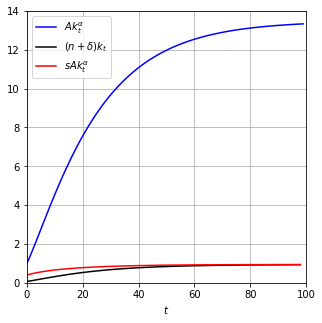

In [94]:
solow_graph_2(1,0.05,0.02,1,0.4,0.33,100);


And with widgets for testing out effects of different parameters

In [95]:
widgets.interact(
        solow_graph_2,
        k_0=widgets.FloatSlider(
            description="k_0", min=0, max=10, step=0.05, value=2
        ),
        alpha=widgets.FloatSlider(
            description="alpha", min=0.01, max=0.99, step=0.01, value=0.3
        ),
        delta=widgets.FloatSlider(
            description="delta", min=0.01, max=0.50, step=0.01, value=0.05
        ),
        s=widgets.FloatSlider(
            description="s", min=0.01, max=0.99, step=0.01, value=0.33
        ),
        n= widgets.FloatSlider(description ='n', min = -0.1 , max = 0.1 , step = 0.005, value = 0.01),
        A     = widgets.fixed(1),
        t     = widgets.IntSlider(description='t' , min = 1, max = 150, step = 10,  value = 100),
      
    );

interactive(children=(FloatSlider(value=2.0, description='k_0', max=10.0, step=0.05), FloatSlider(value=0.05, …

# The COVID-19 Extended Solow Model

Given the current global crisis, we wanted to extended the basic Solow model to fit the current climate. Such a model could look like this

In [96]:
Y = sm.symbols("Y_t")          #GDP in the economy
y = sm.symbols("y_t")          #GDP per worker
K = sm.symbols("K_t")          #Capital in the economy
K_next = sm.symbols("K_{t+1}") #Capital in the economy next period
k = sm.symbols("k_t")          #Capital per worker
k_next = sm.symbols("k_{t+1}") #Capital per worker
s = sm.symbols("s")            #Rate of savings
n = sm.symbols("n")            #Population growth
g = sm.symbols("g")            #Growth in technology
A = sm.symbols("A")            #Total factor productivity
L = sm.symbols("L_t")          #Labour
L_next = sm.symbols("L_{t+1}") #Labour next period
alpha = sm.symbols("alpha")    #Return on capital
delta = sm.symbols("delta")    #Depreciation rate on capital
kstar = sm.symbols("k^*")    #Steady state for capital
ystar = sm.symbols("y^*")      #Steady state for GDP per worker
C = sm.symbols("C")      # Initial destruction of coronavirus lockdown
c = sm.symbols("c")           # definition C/L
D = sm.symbols("D")         # destruction of infection caused by the infection pressure
eta = sm.symbols("eta")       # Infection pressure rate
r = sm.symbols("r_t")          #Real rental rate
w = sm.symbols("w_t")          #Real wage

\begin{equation}
Y_t = AK_t^{\alpha}L_t^{1-\alpha} * D - C \tag{1}
\end{equation}
\begin{equation}
S_t = sY_t \tag{2}
\end{equation}
\begin{equation}
K_{t+1} - K_t = S_t -\delta K_t \tag{3}
\end{equation}
\begin{equation}
L_{t+1} = (1+n)L_t \tag{4}
\end{equation}
\begin{equation}
y_t = \frac{Y_t}{L_t} = Ak_t^{\alpha} \tag{5}
\end{equation}
\begin{equation}
k_t = \frac{K_t}{L_t} \tag{6}
\end{equation}
\begin{equation}
D = \frac{1}{1+\eta} \tag{8}
\end{equation}
\begin{equation}
r_t = \alpha A \left(\frac{K_t}{L_t}\right)^{\alpha-1} D \tag{9}
\end{equation}
\begin{equation}
w_t = (1-\alpha) A \left(\frac{K_t}{L_t}\right)^{\alpha-1} D \tag{10}
\end{equation}

$$t < T$$   before the corona lockdown: $$ C=0,    \eta = 0 $$
$$t = T$$  the corona crisis occurs  : $$ 0<C<1,  \eta > 0 $$
$$t > T$$  reopening                  : $$ 0<C<1,  \eta > 0 $$

As with the basic model, we verify the derivatives of the production function

In [97]:
foc_wrt_K_2 = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha) * D -C, K)),r)
foc_wrt_K_2

Eq(A*D*K_t**(alpha - 1)*L_t**(1 - alpha)*alpha, r_t)

In [98]:
foc_wrt_L_2 = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha) * D -C, L)),w)
foc_wrt_L_2

Eq(-A*D*K_t**alpha*L_t**(-alpha)*(alpha - 1), w_t)

In [99]:
Transition_equation_2 = sm.simplify(sm.Eq((((1/(1+n))*((A*D*k**(alpha)- c)*s+(1-delta)*k))), k_next))
Transition_equation_2

Eq(k_{t+1}, (-k_t*(delta - 1) + s*(A*D*k_t**alpha - c))/(n + 1))

In [100]:
infection_vec = np.array([0.001,0.005,0.001]) # array of diffent infection pressure levels


In [104]:
def solow_equation_2(k, delta, n, A, s, alpha, c, eta,d):
    """  defines the outcomes of the extended Solow model as specified by the model equations
    
    Args:
    
        k     (float): Capital per worker
        delta (float): Depreciation rate on capital
        n     (float): Population growth rate
        A     (float): Total factor productivity
        s     (float): Rate of savings
        alpha (float): Share of capital out of output
        c     (float): Initial destruction of the coronavirus lockdown
        eta   (float): Infection pressure rate
        d     (float): destruction caused by the infection pressure rate

    Returns:
    
      savings            : equation for total production per capita

      depreciation       : equation of total depreciation over time                                   including population growths 
      k_extended         : equation for capital, savings and total                                   depreciation

    """
    savings = s *A* k ** alpha
    depreciation = (delta+n) * k
    k_extended =  1/(1+eta)*(k + savings - depreciation) - d*c*(1/(1+eta))*(k + savings - depreciation)
    return k_extended, savings, depreciation

def solow_graph_3(k_0,delta,n,A,s,alpha,t, c,eta,v,d):
    """  graphs the solow equation above
    
    Args:
    
        k_0   (integer): initial capial
        delta (float): Depreciation rate on capital
        n     (float): Population growth rate
        A     (float): Total factor productivity
        s     (float): Rate of savings
        alpha (float): Share of capital out of output
        t     (integer): Share of capital out of output
        c     (float): Initial destruction of the coronavirus lockdown
        eta   (float): Infection pressure rate
        d     (float): destruction caused by the infection pressure rate
        v     (float): decided at what time the vaccine enters
       

    Returns:
    
      savings            : equation for total production per capita

      depreciation       : equation of total depreciation over time                                   including population growths 
      k_extended         : equation for capital, savings and total                                   depreciation

    """

        #cpaital path
    kvec = [k_0]
        # savings path
    svec = []
        # depreciation path
    deltavec = []

        
    for t_ in range(1, t):
         if (50 < t_*1 < v):
            k_extended, savings, depreciation = solow_equation_2(kvec[t_-1], delta,n,A, s, alpha,c,eta,0)

            kvec.append(k_extended)
            svec.append(savings)
            deltavec.append(depreciation)

         elif (t_*1 == 50):
            k_extended, savings, depreciation = solow_equation_2(kvec[t_-1], delta,n,A, s, alpha,c,eta,d)

            kvec.append(k_extended)
            svec.append(savings)
            deltavec.append(depreciation)     
         else: 
            k_extended, savings, depreciation = solow_equation_2(kvec[t_-1], delta,n,A, s, alpha,c,0,0)

            kvec.append(k_extended)
            svec.append(savings)
            deltavec.append(depreciation)

    plt.figure(figsize=(5,5))
    plt.plot(kvec[:t], label='$Ak_t^{\u03B1}$', color = 'blue')
    plt.plot(deltavec[:t], label = '$(n+\delta)k_t$', color = 'black')
    plt.plot(svec[:t], label = '$sAk_t^{\u03B1}$', color = 'red')
    plt.xlim(0,t)
    plt.ylim(0, )
    plt.xlabel('$t$')
    plt.grid(True)
    plt.legend()
    return plt.plot()

[]

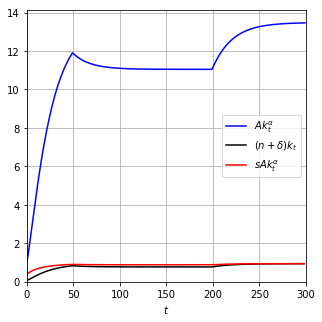

In [105]:
solow_graph_3(1,0.05,0.02,1,0.4,0.33,300,0,0.01,200,1)

In [106]:
widgets.interact(
        solow_graph_3,
        k_0   =widgets.fixed(1),
        alpha =widgets.fixed(0.33),
        delta =widgets.fixed(0.05),
        s     =widgets.fixed(0.4),
        n     = widgets.fixed(0.01),
        A     = widgets.fixed(1),
        d     = widgets.fixed(1),
        t     = widgets.fixed(400),
        c     = widgets.FloatSlider(description="c", min=0.0, max=1, step=0.05, value=0.2),
        eta   = widgets.FloatSlider(description="eta", min=0.000, max=0.1, step=0.001, value=0.01),
        v     = widgets.IntSlider(description="v", min=51, max=300, step=1, value=200),
    );

interactive(children=(FloatSlider(value=0.2, description='c', max=1.0, step=0.05), FloatSlider(value=0.01, des…

# Conclusion

We started this project by setting up the basic Solow model, solving for key properties of the model and graphing the results such as the impact of changes in the savings rate on aggregated wealth. After this we extended the basic Solow model with both long og short term  damage function resembling the impact of the coronavirus, so the model can be used to understand the economic consequences of the current virus epidemic.
